In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# 1. Đọc dữ liệu và parse cột date
train = pd.read_csv('/content/train.csv', parse_dates=["date"])
valid = pd.read_csv('/content/validation.csv', parse_dates=["date"])
test = pd.read_csv('/content/test.csv', parse_dates=["date"])

print("Train:", train.shape)
print("Valid:", valid.shap)
print("Test:", test.shape)

Train: (37620, 15)
Valid: (5374, 15)
Test: (10749, 15)


In [3]:
# 2. Gộp toàn bộ dữ liệu để phân tích
df_all = pd.concat([train, valid, test], ignore_index=True)

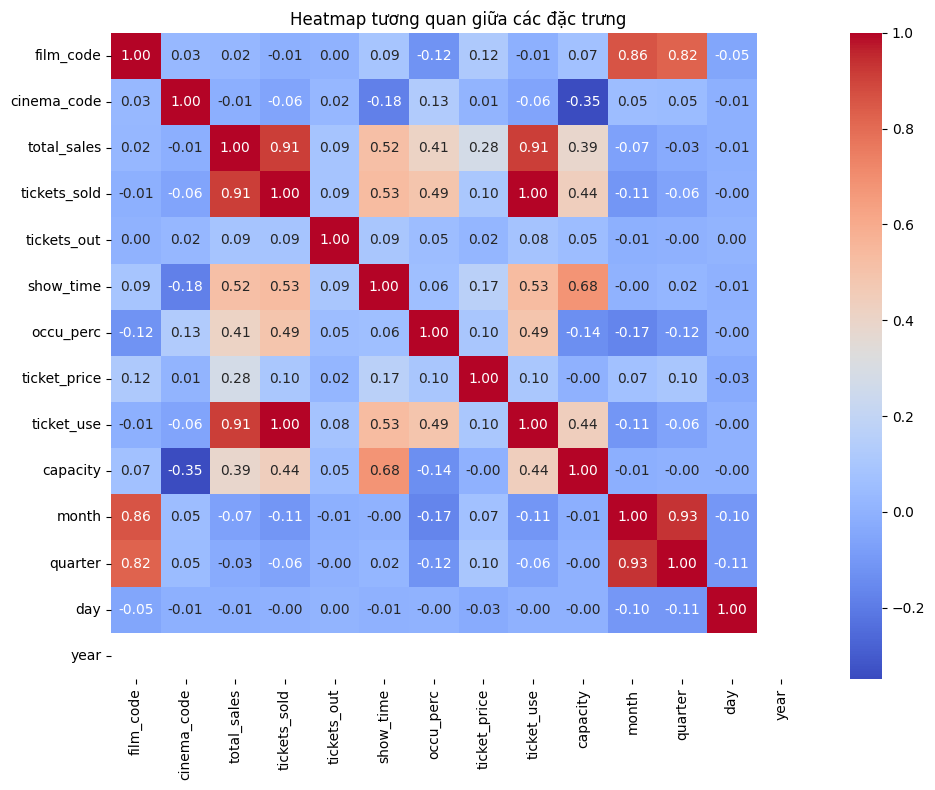

In [4]:
# 3. Vẽ heatmap tương quan
corr_matrix = df_all.select_dtypes(include='number').corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap tương quan giữa các đặc trưng")
plt.tight_layout()
plt.show()

In [5]:
# # 5. Chuẩn hóa dữ liệu và tạo chuỗi thời gian
# features = ['tickets_sold', 'tickets_out', 'show_time', 'occu_perc',
#             'ticket_price', 'ticket_use', 'capacity', 'month', 'quarter', 'day', 'year']
# target = 'total_sales'

# X_train = train[features].values
# y_train = train[target].values

# X_valid = valid[features].values
# y_valid = valid[target].values

# X_test = test[features].values
# y_test = test[target].values

# scaler_X = MinMaxScaler()
# scaler_y = MinMaxScaler()

# X_train = scaler_X.fit_transform(X_train)
# y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

# X_valid = scaler_X.transform(X_valid)
# y_valid_scaled = scaler_y.transform(y_valid.reshape(-1, 1)).flatten()

# X_test = scaler_X.transform(X_test)
# y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

In [6]:
# 5. Chuẩn hóa dữ liệu và tạo chuỗi thời gian
sequence_length = 30
features = ['tickets_sold', 'tickets_out', 'show_time', 'occu_perc',
            'ticket_price', 'ticket_use', 'capacity', 'month', 'quarter', 'day', 'year']
target = 'total_sales'

train_valid = pd.concat([train, valid], ignore_index=True)
df_model = pd.concat([train_valid, test], ignore_index=True)

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_x.fit_transform(df_model[features])
y_scaled = scaler_y.fit_transform(df_model[[target]])

In [7]:
# # Nối train, valid, test lại để tạo sequence toàn bộ cho forecast tiếp sau test
# X_scaled = np.concatenate([X_train, X_valid, X_test], axis=0)
# y_scaled = np.concatenate([y_train_scaled, y_valid_scaled, y_test_scaled], axis=0)

In [8]:
# 6. Chỉ tạo sequence trên toàn bộ dữ liệu (để forecast tiếp từ cuối test)
sequence_length = 30

def create_sequences(x, y, seq_len):
    xs, ys = [], []
    for i in range(seq_len, len(x)):
        xs.append(x[i - seq_len:i])
        ys.append(y[i])
    return np.array(xs), np.array(ys)

X_all, y_all = create_sequences(X_scaled, y_scaled, sequence_length)

In [9]:
# # 7. Dùng train + valid để train mô hình (loại bỏ phần test)
# train_valid_len = len(X_train) + len(X_valid)

# # Cần trừ sequence_length vì các sequence đầu tiên không đủ độ dài
# X_train_gru = X_all[:train_valid_len - sequence_length]
# y_train_gru = y_all[:train_valid_len - sequence_length]

# #Tách phần test để dự báo sau này
# X_test_gru = X_all[train_valid_len - sequence_length:]
# y_test_gru = y_all[train_valid_len - sequence_length:]

In [12]:
# 7. Dùng train + valid để train mô hình
train_valid_len = len(train_valid)
X_train_gru = X_all[:train_valid_len - sequence_length]
y_train_gru = y_all[:train_valid_len - sequence_length]

#Tách phần test để dự báo sau này
X_test_gru = X_all[train_valid_len - sequence_length:]
y_test_gru = y_all[train_valid_len - sequence_length:]

In [13]:
# 8. Xây dựng mô hình GRU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(GRU(
    128,
    return_sequences=True,
    input_shape=(sequence_length, len(features))
))
model.add(Dropout(0.2))
model.add(GRU(64))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_gru, y_train_gru,
    epochs=30,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0012
Epoch 2/30
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - loss: 6.2494e-04
Epoch 3/30
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 7.6903e-04
Epoch 4/30
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 6.5898e-04
Epoch 5/30
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 6.0524e-04
Epoch 6/30
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 5.8066e-04
Epoch 7/30
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 6.7147e-04
Epoch 8/30
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 5.7750e-04
Epoch 9/30
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 6.7092e-04
Epoch 10/30
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 6.2434e-04
Epoch 11/30
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 6.2775e-04
Epoch 12/30
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 6.6345e-04
Epoch 13/30
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 6.2854e-04
Epoch 14/30
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 1

In [14]:
# Đánh giá
# Dự đoán trên tập test GRU
y_pred = model.predict(X_test_gru)

# Đưa kết quả về giá trị thật
y_pred_real = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_real = scaler_y.inverse_transform(y_test_gru.reshape(-1, 1)).flatten()

# Tính các chỉ số đánh giá
mae = mean_absolute_error(y_test_real, y_pred_real)
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
r2 = r2_score(y_test_real, y_pred_real)

print("MAE:", mae)
print("RMSE:", rmse)
print("R² Score:", r2)

336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
MAE: 9650374.101514531
RMSE: 27967715.710174743
R² Score: 0.19968229697570183


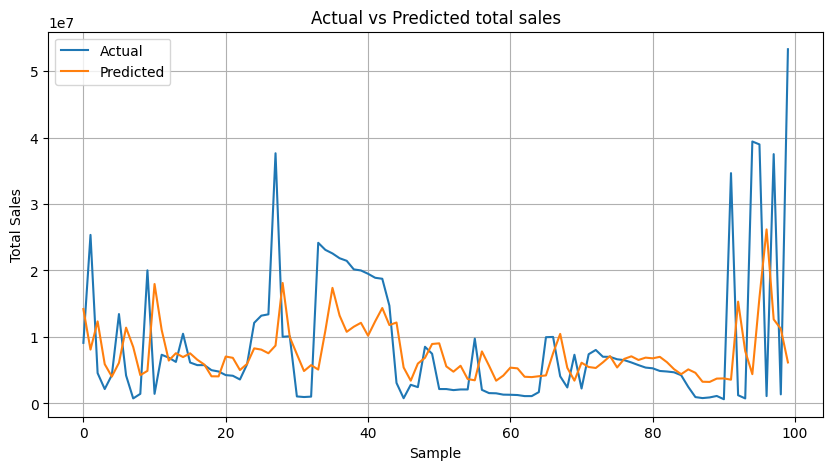

In [15]:
# 6. Vẽ biểu đồ Actual vs Predicted
plt.figure(figsize=(10,5))
plt.plot(y_test_real[:100], label='Actual')
plt.plot(y_pred_real[:100], label='Predicted')
plt.legend()
plt.title('Actual vs Predicted total sales')
plt.xlabel('Sample')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

In [16]:
# 10. Dự đoán 30 ngày tiếp theo từ điểm cuối của test
last_sequence_input = X_scaled[-sequence_length:].reshape(1, sequence_length, len(features))
future_preds = []

for _ in range(30):
    next_pred = model.predict(last_sequence_input, verbose=0)[0][0]
    future_preds.append(next_pred)

    # Giữ nguyên các đặc trưng cuối (vì không dự đoán được input mới)
    next_features = last_sequence_input[0, -1, :].copy()
    last_sequence_input = np.append(last_sequence_input[:, 1:, :], [[next_features]], axis=1)

# Chuyển dự đoán về dạng thực
future_preds_real = scaler_y.inverse_transform(np.array(future_preds).reshape(-1, 1)).flatten()

# Lấy ngày cuối cùng từ dữ liệu gốc
df_all = pd.concat([train, valid, test]).reset_index(drop=True)
last_date = df_all['date'].iloc[-1]

# Tạo danh sách ngày tương lai
future_dates = pd.date_range(start = last_date + pd.Timedelta(days=1), periods=30)

In [17]:
# Tạo DataFrame chứa dự đoán
future_df = pd.DataFrame({
    'date': future_dates,
    'total_sales': future_preds_real,
    'type': 'Forecasted Sales'})
print(future_df)

         date  total_sales              type
0  2018-12-11   19237422.0  Forecasted Sales
1  2018-12-12   20432944.0  Forecasted Sales
2  2018-12-13   18471186.0  Forecasted Sales
3  2018-12-14   18180894.0  Forecasted Sales
4  2018-12-15   19446076.0  Forecasted Sales
5  2018-12-16   19488070.0  Forecasted Sales
6  2018-12-17   19662924.0  Forecasted Sales
7  2018-12-18   19732930.0  Forecasted Sales
8  2018-12-19   19891310.0  Forecasted Sales
9  2018-12-20   20084006.0  Forecasted Sales
10 2018-12-21   20014688.0  Forecasted Sales
11 2018-12-22   20027916.0  Forecasted Sales
12 2018-12-23   20022154.0  Forecasted Sales
13 2018-12-24   20069374.0  Forecasted Sales
14 2018-12-25   20132518.0  Forecasted Sales
15 2018-12-26   20176734.0  Forecasted Sales
16 2018-12-27   20199344.0  Forecasted Sales
17 2018-12-28   20234926.0  Forecasted Sales
18 2018-12-29   20307808.0  Forecasted Sales
19 2018-12-30   20298430.0  Forecasted Sales
20 2018-12-31   20325584.0  Forecasted Sales
21 2019-01

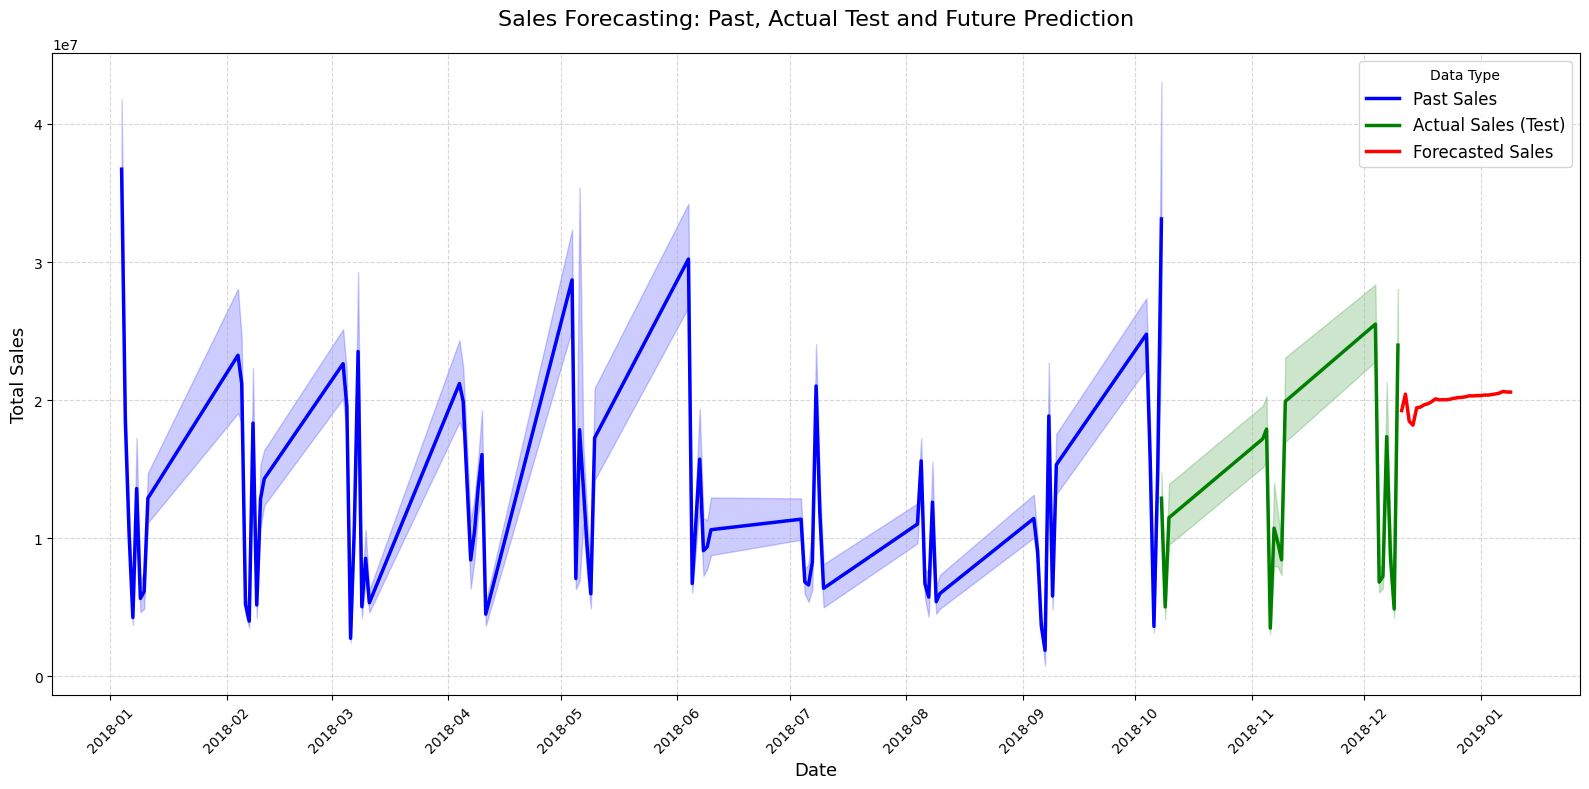

In [18]:
# 11. Vẽ biểu đồ
# Chuẩn bị dữ liệu quá khứ để visualization
train['type'] = 'Past Sales'
valid['type'] = 'Past Sales'
test['type'] = 'Actual Sales (Test)'  # Thêm thông tin cho test data

# Gộp tất cả dữ liệu
combined_df = pd.concat([
    train[['date', 'total_sales', 'type']],
    valid[['date', 'total_sales', 'type']],
    test[['date', 'total_sales', 'type']],
    future_df
], ignore_index=True)

# Vẽ đồ thị
plt.figure(figsize=(16, 8))
sns.lineplot(
    data=combined_df,
    x='date',
    y='total_sales',
    hue='type',
    style='type',
    dashes=False,
    palette={
        'Past Sales': 'blue',
        'Actual Sales (Test)': 'green',
        'Forecasted Sales': 'red'
    },
    linewidth=2.5
)

# Định dạng trục x
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

# Thêm các chi tiết cho đồ thị
plt.xlabel('Date', fontsize=13)
plt.ylabel('Total Sales', fontsize=13)
plt.title('Sales Forecasting: Past, Actual Test and Future Prediction', fontsize=16, pad=20)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Data Type', fontsize=12)
plt.tight_layout()
plt.show()